# Waymo Emergency Vehicle Detection with YOLO

### Initializing Data from GCP Bucket

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from google.cloud import storage
import shutil

# Install required packages if needed
# !pip install -q google-cloud-storage

# Authenticate to Google Cloud
from google.colab import auth
auth.authenticate_user()

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
DATA_DIR = os.path.join(BASE_DIR, "data")
VIDEOS_DIR = os.path.join(DATA_DIR, "videos")
FRAMES_DIR = os.path.join(DATA_DIR, "frames")
LABELS_DIR = os.path.join(DATA_DIR, "labels")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")

# Create directories
for directory in [DATA_DIR, VIDEOS_DIR, FRAMES_DIR, LABELS_DIR, YOLO_DIR]:
    os.makedirs(directory, exist_ok=True)

# Split directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(VIDEOS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(FRAMES_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(LABELS_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DIR, split, "labels"), exist_ok=True)

# Initialize GCP client
client = storage.Client()
bucket_name = "waymo_open_dataset_road_plus_plus"
bucket = client.bucket(bucket_name)

In [2]:
# List all blobs (files) in the bucket
blobs = bucket.list_blobs()

for blob in blobs:
    print(blob.name)

road_waymo_trainval_v1.0.json
test_videos/val_00000.mp4
test_videos/val_00001.mp4
test_videos/val_00002.mp4
test_videos/val_00003.mp4
test_videos/val_00004.mp4
test_videos/val_00005.mp4
test_videos/val_00006.mp4
test_videos/val_00007.mp4
test_videos/val_00008.mp4
test_videos/val_00009.mp4
test_videos/val_00010.mp4
test_videos/val_00011.mp4
test_videos/val_00012.mp4
test_videos/val_00013.mp4
test_videos/val_00014.mp4
test_videos/val_00015.mp4
test_videos/val_00016.mp4
test_videos/val_00017.mp4
test_videos/val_00018.mp4
test_videos/val_00019.mp4
test_videos/val_00020.mp4
test_videos/val_00021.mp4
test_videos/val_00022.mp4
test_videos/val_00023.mp4
test_videos/val_00024.mp4
test_videos/val_00025.mp4
test_videos/val_00026.mp4
test_videos/val_00027.mp4
test_videos/val_00028.mp4
test_videos/val_00029.mp4
test_videos/val_00030.mp4
test_videos/val_00031.mp4
test_videos/val_00032.mp4
test_videos/val_00033.mp4
test_videos/val_00034.mp4
test_videos/val_00035.mp4
test_videos/val_00036.mp4
test_vid

In [3]:
import json

# Download a specific file
blob = bucket.blob('road_waymo_trainval_v1.0.json')
blob.download_to_filename('road_waymo_trainval_v1.0.json')
with open('/content/road_waymo_trainval_v1.0.json', 'r') as file:
    data = json.load(file)

### Data Preprocessing

In [4]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
import shutil
from google.cloud import storage
import matplotlib.pyplot as plt

# Load the JSON data
with open('road_waymo_trainval_v1.0.json', 'r') as file:
    data = json.load(file)

# Define class indices for reference
agent_labels = data['agent_labels']
emveh_idx = agent_labels.index('EmVeh')
print(f"Emergency Vehicle class index: {emveh_idx}")

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
FRAMES_DIR = os.path.join(BASE_DIR, "data/frames")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")

# Define metadata to track statistics
dataset_stats = {
    'total_sequences': 0,
    'sequences_with_emergency': 0,
    'total_frames': 0,
    'frames_with_emergency': 0,
    'total_emergency_instances': 0,
    'emergency_frames_by_sequence': {}
}

# Function to convert coordinates from [x_min, y_min, x_max, y_max] to YOLO [x_center, y_center, width, height]
def convert_to_yolo_format(box, img_width, img_height):
    # Assuming box is [x_min, y_min, x_max, y_max] in normalized coordinates
    x_min, y_min, x_max, y_max = box

    # Calculate center coordinates and dimensions (normalized)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return [x_center, y_center, width, height]

# Function to explore all sequences in the dataset for emergency vehicles
def find_all_emergency_vehicles():
    """Find all frames containing emergency vehicles and collect statistics"""

    # Initialize collection of emergency vehicle annotations
    emergency_annotations = {}

    # Iterate through all sequences
    for sequence_id, sequence_data in tqdm(data['db'].items(), desc="Analyzing sequences"):
        dataset_stats['total_sequences'] += 1
        frames_in_seq = 0
        emergency_frames_in_seq = 0

        # Check if this sequence contains any frames
        if 'frames' not in sequence_data:
            continue

        # Get all frames in this sequence
        frames = sequence_data.get('frames', {})

        # Iterate through all frames
        for frame_id, frame_data in frames.items():
            dataset_stats['total_frames'] += 1
            frames_in_seq += 1

            # Get the annotations for this frame
            if 'annos' not in frame_data:
                continue

            annotations = frame_data['annos']

            # Look for emergency vehicles in the annotations
            emergency_instances = []

            for anno_id, anno_data in annotations.items():
                # Check if the annotation includes agent_ids
                if not isinstance(anno_data, dict) or 'agent_ids' not in anno_data:
                    continue

                # Check if agent_ids contains emergency vehicle index
                if emveh_idx in anno_data['agent_ids']:
                    # Found an emergency vehicle!
                    if 'box' in anno_data:
                        # Add this instance to our collection
                        emergency_instances.append({
                            'box': anno_data['box'],
                            'frame_id': frame_id,
                            'rgb_image_id': frame_data.get('rgb_image_id'),
                            'width': frame_data.get('width', 1920),
                            'height': frame_data.get('height', 1280)
                        })

            # If we found emergency vehicles in this frame, update statistics
            if emergency_instances:
                dataset_stats['frames_with_emergency'] += 1
                emergency_frames_in_seq += 1
                dataset_stats['total_emergency_instances'] += len(emergency_instances)

                # Store the annotations
                if sequence_id not in emergency_annotations:
                    emergency_annotations[sequence_id] = {}

                emergency_annotations[sequence_id][frame_id] = {
                    'instances': emergency_instances,
                    'rgb_image_id': frame_data.get('rgb_image_id'),
                    'width': frame_data.get('width', 1920),
                    'height': frame_data.get('height', 1280)
                }

        # Update statistics for this sequence
        if emergency_frames_in_seq > 0:
            dataset_stats['sequences_with_emergency'] += 1
            dataset_stats['emergency_frames_by_sequence'][sequence_id] = emergency_frames_in_seq

    # Print statistics
    print(f"Found {dataset_stats['total_emergency_instances']} emergency vehicle instances")
    print(f"in {dataset_stats['frames_with_emergency']} frames across {dataset_stats['sequences_with_emergency']} sequences")

    # Return the collected annotations
    return emergency_annotations

# Function to prepare YOLO dataset
def prepare_yolo_dataset(emergency_annotations, split_ratio=0.8):
    """
    Prepare the YOLO dataset from the annotations

    Args:
        emergency_annotations: Dictionary of annotations by sequence and frame
        split_ratio: Train/val split ratio (default: 0.8)
    """
    # Get all sequence IDs with emergency vehicles
    sequence_ids = list(emergency_annotations.keys())

    # Shuffle and split into train/val
    random.shuffle(sequence_ids)
    split_idx = int(len(sequence_ids) * split_ratio)
    train_sequences = sequence_ids[:split_idx]
    val_sequences = sequence_ids[split_idx:]

    print(f"Split: {len(train_sequences)} train sequences, {len(val_sequences)} validation sequences")

    # Create an image mapping file to document where the source images should be
    image_mapping = {
        'train': {},
        'val': {}
    }

    # Function to process annotations for a split
    def process_split(split_name, sequence_ids):
        count = 0

        for sequence_id in tqdm(sequence_ids, desc=f"Processing {split_name} split"):
            for frame_id, frame_data in emergency_annotations[sequence_id].items():
                rgb_image_id = frame_data['rgb_image_id']
                width = frame_data['width']
                height = frame_data['height']

                # Generate a unique output filename
                output_name = f"{sequence_id}_{frame_id}"

                # Record the image mapping
                image_mapping[split_name][output_name] = {
                    'sequence_id': sequence_id,
                    'frame_id': frame_id,
                    'rgb_image_id': rgb_image_id
                }

                # Create YOLO annotation file
                with open(os.path.join(YOLO_DIR, split_name, 'labels', f"{output_name}.txt"), 'w') as f:
                    for instance in frame_data['instances']:
                        box = instance['box']

                        # Convert box to YOLO format: class_id x_center y_center width height
                        yolo_box = convert_to_yolo_format(box, width, height)

                        # Write the annotation
                        f.write(f"0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n")

                # Create a placeholder image file for now
                # Later we'll replace this with the actual image or use this as a reference
                placeholder_path = os.path.join(YOLO_DIR, split_name, 'images', f"{output_name}.jpg")
                with open(placeholder_path, 'w') as f:
                    f.write(f"Placeholder for {sequence_id}, frame {frame_id}, rgb_image_id {rgb_image_id}")

                count += 1

        return count

    # Process train and validation splits
    train_count = process_split('train', train_sequences)
    val_count = process_split('val', val_sequences)

    print(f"Created YOLO dataset with {train_count} training images and {val_count} validation images")

    # Save the image mapping for future reference
    with open(os.path.join(BASE_DIR, 'image_mapping.json'), 'w') as f:
        json.dump(image_mapping, f, indent=2)

    return image_mapping

# Function to attempt to download images from Waymo bucket
def attempt_to_download_images(image_mapping):
    """
    Attempts to download images from Waymo bucket based on rgb_image_id
    This is a starting point and may need modification
    """
    # Initialize GCP client
    client = storage.Client()
    bucket_name = "waymo_open_dataset_road_plus_plus"
    bucket = client.bucket(bucket_name)

    # Try different possible path formats
    possible_path_formats = [
        # Format 1: direct ID
        "{rgb_image_id}.jpg",
        # Format 2: sequence folder
        "{sequence_id}/{rgb_image_id}.jpg",
        # Format 3: frames folder
        "frames/{sequence_id}/{rgb_image_id}.jpg",
        # Format 4: images folder
        "images/{sequence_id}/{rgb_image_id}.jpg",
        # Format 5: sequence_frame format
        "{sequence_id}_{frame_id}.jpg"
    ]

    # Try to download a sample of images
    sample_count = min(10, sum(len(seq_frames) for seq_frames in image_mapping['train'].values()) +
                          sum(len(seq_frames) for seq_frames in image_mapping['val'].values()))

    downloaded = 0

    print(f"Attempting to download {sample_count} sample images...")

    # Flatten the image mapping for sampling
    all_images = []
    for split in ['train', 'val']:
        for output_name, image_info in image_mapping[split].items():
            all_images.append((split, output_name, image_info))

    # Sample a subset
    sample_images = random.sample(all_images, min(sample_count, len(all_images)))

    for split, output_name, image_info in sample_images:
        # Try each possible path format
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(
                    sequence_id=image_info['sequence_id'],
                    frame_id=image_info['frame_id'],
                    rgb_image_id=image_info['rgb_image_id']
                )

                local_path = os.path.join(YOLO_DIR, split, 'images', f"{output_name}.jpg")

                print(f"Trying to download {remote_path}...")

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_path)
                    print(f"Downloaded {remote_path} to {local_path}")
                    downloaded += 1
                    break
            except Exception as e:
                print(f"Error trying {path_format}: {e}")

    print(f"Downloaded {downloaded} out of {sample_count} attempted images")

    # If no images were downloaded, we need to explore the bucket structure more
    if downloaded == 0:
        print("Could not download any images. Exploring bucket structure...")

        # List blobs to understand structure
        # This will list the first 1000 blobs
        blobs = list(bucket.list_blobs(max_results=1000))

        if blobs:
            print("Sample blob names:")
            for i, blob in enumerate(blobs[:20]):
                print(f"  {i+1}. {blob.name}")
        else:
            print("No blobs found in the bucket. Check permissions and bucket name.")

    return downloaded

# Main execution
if __name__ == "__main__":
    # Find all emergency vehicle instances
    print("Searching for emergency vehicles in the dataset...")
    emergency_annotations = find_all_emergency_vehicles()

    # Save the annotations for reference
    with open(os.path.join(BASE_DIR, 'emergency_annotations.json'), 'w') as f:
        json.dump(emergency_annotations, f, indent=2)

    # Prepare the YOLO dataset
    if emergency_annotations:
        print("\nPreparing YOLO dataset...")
        image_mapping = prepare_yolo_dataset(emergency_annotations)

        # Try to download images
        print("\nAttempting to download actual images...")
        downloaded = attempt_to_download_images(image_mapping)

        # If we couldn't download the images, provide instructions
        if downloaded == 0:
            print("\nCould not automatically download images.")
            print("You'll need to:")
            print("1. Investigate the actual image storage structure in the Waymo dataset")
            print("2. Update the 'attempt_to_download_images' function with the correct path format")
            print("3. Re-run the download process")

        print("\nYOLO dataset preparation complete!")
        print(f"Dataset statistics:")
        for key, value in dataset_stats.items():
            if key != 'emergency_frames_by_sequence':  # Skip the detailed sequence data
                print(f"  {key}: {value}")
    else:
        print("No emergency vehicle instances found in the dataset.")

Emergency Vehicle class index: 8
Searching for emergency vehicles in the dataset...


Analyzing sequences: 100%|██████████| 798/798 [00:02<00:00, 334.55it/s]


Found 2139 emergency vehicle instances
in 2139 frames across 27 sequences

Preparing YOLO dataset...
Split: 21 train sequences, 6 validation sequences


Processing val split: 100%|██████████| 6/6 [00:00<00:00, 82.56it/s]


Created YOLO dataset with 1317 training images and 822 validation images

Attempting to download actual images...
Attempting to download 10 sample images...
Trying to download 96.jpg...
Trying to download train_00164/96.jpg...
Trying to download frames/train_00164/96.jpg...
Trying to download images/train_00164/96.jpg...
Trying to download train_00164_96.jpg...
Trying to download 15.jpg...
Trying to download train_00016/15.jpg...
Trying to download frames/train_00016/15.jpg...
Trying to download images/train_00016/15.jpg...
Trying to download train_00016_15.jpg...
Trying to download 186.jpg...
Trying to download train_00229/186.jpg...
Trying to download frames/train_00229/186.jpg...
Trying to download images/train_00229/186.jpg...
Trying to download train_00229_186.jpg...
Trying to download 65.jpg...
Trying to download train_00502/65.jpg...
Trying to download frames/train_00502/65.jpg...
Trying to download images/train_00502/65.jpg...
Trying to download train_00502_65.jpg...
Trying to 

In [5]:
import os
import json
import cv2
import numpy as np
from tqdm import tqdm
import random
from google.cloud import storage

# Load our previously generated mappings
with open('/content/waymo_emergency_vehicle_detection/image_mapping.json', 'r') as f:
    image_mapping = json.load(f)

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
VIDEOS_DIR = os.path.join(BASE_DIR, "data/videos")
FRAMES_DIR = os.path.join(BASE_DIR, "data/frames")
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")

# Make sure directories exist
os.makedirs(VIDEOS_DIR, exist_ok=True)
os.makedirs(FRAMES_DIR, exist_ok=True)

# Function to download videos from the bucket
def download_videos():
    """Download the required videos from the Waymo bucket"""

    # Initialize GCP client
    client = storage.Client()
    bucket_name = "waymo_open_dataset_road_plus_plus"
    bucket = client.bucket(bucket_name)

    # Gather unique sequence IDs from our annotations
    sequence_ids = set()
    for split in ['train', 'val']:
        for output_name, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            sequence_ids.add(sequence_id)

    print(f"Need to download {len(sequence_ids)} video sequences")

    # Try different possible video path formats
    possible_path_formats = [
        "videos/{sequence_id}.mp4",
        "test_videos/{sequence_id}.mp4",
        "train_videos/{sequence_id}.mp4",
        "{sequence_id}.mp4"
    ]

    # Download each video
    downloaded = 0
    for sequence_id in tqdm(sequence_ids, desc="Downloading videos"):
        # Check if already downloaded
        local_video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
        if os.path.exists(local_video_path):
            print(f"Video {sequence_id}.mp4 already exists, skipping...")
            downloaded += 1
            continue

        # Try each possible path format
        for path_format in possible_path_formats:
            try:
                remote_path = path_format.format(sequence_id=sequence_id)

                print(f"Trying to download {remote_path}...")

                blob = bucket.blob(remote_path)
                if blob.exists():
                    blob.download_to_filename(local_video_path)
                    print(f"Downloaded {remote_path} to {local_video_path}")
                    downloaded += 1
                    break
            except Exception as e:
                print(f"Error trying {path_format}: {e}")

    print(f"Downloaded {downloaded} out of {len(sequence_ids)} required videos")

    # If couldn't download, try listing the bucket to find video paths
    if downloaded < len(sequence_ids):
        print("Could not download all required videos. Exploring bucket structure...")

        # List blobs to find video files
        print("Searching for video files in the bucket...")
        blobs = [b for b in bucket.list_blobs() if b.name.endswith('.mp4')]

        if blobs:
            print(f"Found {len(blobs)} video files in the bucket:")
            for i, blob in enumerate(sorted(b.name for b in blobs)[:20]):
                print(f"  {i+1}. {blob}")

            # Try to map sequence IDs to blob names
            for sequence_id in list(sequence_ids):
                # If already downloaded, skip
                if os.path.exists(os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")):
                    continue

                # Try to find a matching blob
                matching_blobs = [b for b in blobs if sequence_id in b.name]
                if matching_blobs:
                    blob = matching_blobs[0]
                    local_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")
                    try:
                        print(f"Downloading {blob.name} to {local_path}...")
                        blob.download_to_filename(local_path)
                        downloaded += 1
                    except Exception as e:
                        print(f"Error downloading {blob.name}: {e}")
        else:
            print("No video files found in the bucket.")

    return downloaded

# Function to extract frames from videos
def extract_frames():
    """Extract frames from videos based on our annotations"""

    frames_extracted = 0
    failed_extractions = 0

    # Process each split
    for split in ['train', 'val']:
        # Group by sequence_id for efficiency
        by_sequence = {}
        for output_name, image_info in image_mapping[split].items():
            sequence_id = image_info['sequence_id']
            if sequence_id not in by_sequence:
                by_sequence[sequence_id] = []
            by_sequence[sequence_id].append((output_name, image_info))

        # Process each sequence
        for sequence_id, entries in tqdm(by_sequence.items(), desc=f"Extracting {split} frames"):
            video_path = os.path.join(VIDEOS_DIR, f"{sequence_id}.mp4")

            # Check if video exists
            if not os.path.exists(video_path):
                print(f"Video file {video_path} not found, skipping {len(entries)} frames")
                failed_extractions += len(entries)
                continue

            try:
                # Open the video file
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Could not open video file {video_path}")
                    failed_extractions += len(entries)
                    continue

                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                print(f"Video {sequence_id}.mp4: {frame_count} frames at {fps} fps")

                # Extract each frame
                for output_name, image_info in entries:
                    frame_id = image_info['frame_id']
                    frame_index = int(frame_id) - 1  # Convert to 0-based index

                    # Set the frame position
                    if frame_index >= frame_count:
                        print(f"Frame index {frame_index} exceeds video length {frame_count}")
                        failed_extractions += 1
                        continue

                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

                    # Read the frame
                    ret, frame = cap.read()
                    if not ret:
                        print(f"Could not read frame {frame_id} from video {sequence_id}")
                        failed_extractions += 1
                        continue

                    # Save the frame
                    frame_path = os.path.join(YOLO_DIR, split, 'images', f"{output_name}.jpg")
                    cv2.imwrite(frame_path, frame)

                    frames_extracted += 1

                # Release the video
                cap.release()

            except Exception as e:
                print(f"Error processing video {sequence_id}: {e}")
                failed_extractions += len(entries)

    print(f"Extracted {frames_extracted} frames, failed to extract {failed_extractions} frames")
    return frames_extracted

# Function to verify YOLO dataset
def verify_yolo_dataset():
    """Verify that the YOLO dataset is correctly set up"""

    # Check train and val splits
    dataset_stats = {
        'train_images': 0,
        'train_labels': 0,
        'val_images': 0,
        'val_labels': 0,
        'missing_images': 0,
        'missing_labels': 0
    }

    for split in ['train', 'val']:
        images_dir = os.path.join(YOLO_DIR, split, 'images')
        labels_dir = os.path.join(YOLO_DIR, split, 'labels')

        # Count image and label files
        image_files = set(f for f in os.listdir(images_dir) if f.endswith('.jpg'))
        label_files = set(f for f in os.listdir(labels_dir) if f.endswith('.txt'))

        # Convert label extensions for comparison
        label_bases = set(os.path.splitext(f)[0] for f in label_files)
        image_bases = set(os.path.splitext(f)[0] for f in image_files)

        # Calculate statistics
        dataset_stats[f'{split}_images'] = len(image_files)
        dataset_stats[f'{split}_labels'] = len(label_files)

        # Check for mismatches
        missing_images = label_bases - image_bases
        missing_labels = image_bases - label_bases

        if missing_images:
            print(f"WARNING: {len(missing_images)} labels in {split} set have no corresponding images")
            dataset_stats['missing_images'] += len(missing_images)

        if missing_labels:
            print(f"WARNING: {len(missing_labels)} images in {split} set have no corresponding labels")
            dataset_stats['missing_labels'] += len(missing_labels)

    # Print summary
    print("\nYOLO Dataset Verification:")
    print(f"Training set: {dataset_stats['train_images']} images, {dataset_stats['train_labels']} labels")
    print(f"Validation set: {dataset_stats['val_images']} images, {dataset_stats['val_labels']} labels")
    print(f"Missing images: {dataset_stats['missing_images']}")
    print(f"Missing labels: {dataset_stats['missing_labels']}")

    # Create a simple visualization of some annotated images
    print("\nCreating sample visualizations...")
    visualize_samples(3, 'train')
    visualize_samples(3, 'val')

# Function to visualize sample images with annotations
def visualize_samples(num_samples, split):
    """Visualize sample images with bounding boxes for verification"""

    images_dir = os.path.join(YOLO_DIR, split, 'images')
    labels_dir = os.path.join(YOLO_DIR, split, 'labels')

    # Get image files with corresponding labels
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') and
                   os.path.exists(os.path.join(labels_dir, f.replace('.jpg', '.txt')))]

    if not image_files:
        print(f"No suitable images found for visualization in {split} set")
        return

    # Select random samples
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    for image_file in samples:
        # Load image
        image_path = os.path.join(images_dir, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image {image_path}")
            continue

        # Get dimensions
        height, width, _ = img.shape

        # Load annotations
        label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

        # Draw bounding boxes
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, box_width, box_height = map(float, parts)

                    # Convert YOLO format to pixel coordinates
                    x_center *= width
                    y_center *= height
                    box_width *= width
                    box_height *= height

                    x1 = int(x_center - box_width / 2)
                    y1 = int(y_center - box_height / 2)
                    x2 = int(x_center + box_width / 2)
                    y2 = int(y_center + box_height / 2)

                    # Draw rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # Add label
                    label = f"EmVeh ({class_id})"
                    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Save visualized image
        output_path = os.path.join(BASE_DIR, f"sample_{split}_{image_file}")
        cv2.imwrite(output_path, img)
        print(f"Saved visualization to {output_path}")

# Create YOLO dataset.yaml file
def create_yaml_config():
    """Create the dataset.yaml configuration file for YOLO training"""

    yaml_content = f"""# Waymo Road++ Emergency Vehicle Detection Dataset
path: {YOLO_DIR}
train: train/images
val: val/images

# Classes
names:
  0: EmVeh  # Emergency Vehicle
"""

    yaml_path = os.path.join(YOLO_DIR, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)

    print(f"Created YOLO configuration file at {yaml_path}")

# Main execution
if __name__ == "__main__":
    # Step 1: Download videos
    print("Step 1: Downloading videos...")
    download_videos()

    # Step 2: Extract frames
    print("\nStep 2: Extracting frames from videos...")
    extract_frames()

    # Step 3: Verify dataset
    print("\nStep 3: Verifying YOLO dataset...")
    verify_yolo_dataset()

    # Step 4: Create YOLO config
    print("\nStep 4: Creating YOLO config file...")
    create_yaml_config()

    print("\nAll done! Your YOLO dataset is ready for training.")

Step 1: Downloading videos...
Need to download 27 video sequences


Trying to download videos/train_00706.mp4...


Downloaded videos/train_00706.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00706.mp4
Trying to download videos/train_00164.mp4...
Downloaded videos/train_00164.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00164.mp4
Trying to download videos/train_00760.mp4...


Downloaded videos/train_00760.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00760.mp4
Trying to download videos/train_00094.mp4...
Downloaded videos/train_00094.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00094.mp4
Trying to download videos/train_00502.mp4...


Downloaded videos/train_00502.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00502.mp4
Trying to download videos/train_00269.mp4...
Downloaded videos/train_00269.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00269.mp4
Trying to download videos/train_00077.mp4...


Downloaded videos/train_00077.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00077.mp4
Trying to download videos/train_00402.mp4...
Downloaded videos/train_00402.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00402.mp4
Trying to download videos/train_00647.mp4...


Downloaded videos/train_00647.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00647.mp4
Trying to download videos/train_00599.mp4...
Downloaded videos/train_00599.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4
Trying to download videos/train_00016.mp4...


Downloaded videos/train_00016.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00016.mp4
Trying to download videos/train_00581.mp4...
Downloaded videos/train_00581.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00581.mp4
Trying to download videos/train_00251.mp4...


Downloaded videos/train_00251.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00251.mp4
Trying to download videos/train_00430.mp4...


Downloaded videos/train_00430.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00430.mp4
Trying to download videos/train_00229.mp4...
Downloaded videos/train_00229.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00229.mp4
Trying to download videos/train_00022.mp4...


Downloaded videos/train_00022.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00022.mp4
Trying to download videos/train_00610.mp4...
Downloaded videos/train_00610.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00610.mp4
Trying to download videos/train_00540.mp4...


Downloaded videos/train_00540.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00540.mp4
Trying to download videos/train_00049.mp4...
Downloaded videos/train_00049.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00049.mp4
Trying to download videos/train_00790.mp4...


Downloaded videos/train_00790.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00790.mp4
Trying to download videos/train_00469.mp4...
Downloaded videos/train_00469.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00469.mp4
Trying to download videos/train_00422.mp4...


Downloaded videos/train_00422.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00422.mp4
Trying to download videos/train_00079.mp4...
Downloaded videos/train_00079.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00079.mp4
Trying to download videos/train_00324.mp4...


Downloaded videos/train_00324.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00324.mp4
Trying to download videos/train_00560.mp4...
Downloaded videos/train_00560.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00560.mp4
Trying to download videos/train_00104.mp4...


Downloaded videos/train_00104.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00104.mp4
Trying to download videos/train_00394.mp4...
Downloaded videos/train_00394.mp4 to /content/waymo_emergency_vehicle_detection/data/videos/train_00394.mp4
Downloaded 27 out of 27 required videos

Step 2: Extracting frames from videos...


Extracting train frames:   0%|          | 0/21 [00:00<?, ?it/s]

Video train_00077.mp4: 198 frames at 10.0 fps


Extracting train frames:   5%|▍         | 1/21 [00:15<05:06, 15.30s/it]

Video train_00560.mp4: 199 frames at 10.0 fps


Extracting train frames:  14%|█▍        | 3/21 [00:33<02:48,  9.38s/it]

Video train_00049.mp4: 199 frames at 10.0 fps
Video train_00706.mp4: 186 frames at 10.0 fps


Extracting train frames:  19%|█▉        | 4/21 [00:37<02:02,  7.21s/it]

Video train_00469.mp4: 198 frames at 10.0 fps


Extracting train frames:  24%|██▍       | 5/21 [00:43<01:47,  6.73s/it]

Video train_00760.mp4: 198 frames at 10.0 fps


Extracting train frames:  29%|██▊       | 6/21 [01:04<02:55, 11.70s/it]

Video train_00402.mp4: 199 frames at 10.0 fps


Extracting train frames:  33%|███▎      | 7/21 [01:07<02:03,  8.79s/it]

Video train_00324.mp4: 199 frames at 10.0 fps


Extracting train frames:  38%|███▊      | 8/21 [01:09<01:25,  6.56s/it]

Video train_00104.mp4: 198 frames at 10.0 fps


Extracting train frames:  43%|████▎     | 9/21 [01:10<00:57,  4.77s/it]

Video train_00610.mp4: 198 frames at 10.0 fps


Extracting train frames:  48%|████▊     | 10/21 [01:14<00:51,  4.64s/it]

Video train_00229.mp4: 198 frames at 10.0 fps


Extracting train frames:  52%|█████▏    | 11/21 [01:24<01:00,  6.09s/it]

Video train_00079.mp4: 199 frames at 10.0 fps


Extracting train frames:  57%|█████▋    | 12/21 [01:37<01:14,  8.26s/it]

Video train_00540.mp4: 199 frames at 10.0 fps


Extracting train frames:  62%|██████▏   | 13/21 [02:48<03:38, 27.29s/it]

Video train_00790.mp4: 199 frames at 10.0 fps


Extracting train frames:  67%|██████▋   | 14/21 [03:18<03:16, 28.12s/it]

Video train_00394.mp4: 196 frames at 10.0 fps


Extracting train frames:  71%|███████▏  | 15/21 [03:22<02:04, 20.80s/it]

Video train_00430.mp4: 199 frames at 10.0 fps


Extracting train frames:  76%|███████▌  | 16/21 [03:43<01:44, 20.98s/it]

Video train_00251.mp4: 199 frames at 10.0 fps


Extracting train frames:  81%|████████  | 17/21 [03:53<01:10, 17.63s/it]

Video train_00422.mp4: 199 frames at 10.0 fps


Extracting train frames:  86%|████████▌ | 18/21 [04:44<01:23, 27.67s/it]

Video train_00647.mp4: 199 frames at 10.0 fps


Extracting train frames:  90%|█████████ | 19/21 [04:55<00:45, 22.62s/it]

Video train_00502.mp4: 199 frames at 10.0 fps


Extracting train frames:  95%|█████████▌| 20/21 [05:33<00:27, 27.24s/it]

Video train_00094.mp4: 198 frames at 10.0 fps


Extracting val frames:   0%|          | 0/6 [00:00<?, ?it/s]

Video train_00269.mp4: 198 frames at 10.0 fps


Extracting val frames:  17%|█▋        | 1/6 [01:08<05:40, 68.02s/it]

Video train_00016.mp4: 199 frames at 10.0 fps


Extracting val frames:  33%|███▎      | 2/6 [01:12<02:02, 30.54s/it]

Video train_00164.mp4: 199 frames at 10.0 fps


Extracting val frames:  50%|█████     | 3/6 [01:50<01:42, 34.25s/it]

Video train_00022.mp4: 199 frames at 10.0 fps


Extracting val frames:  67%|██████▋   | 4/6 [02:55<01:32, 46.33s/it]

Video train_00599.mp4: 198 frames at 10.0 fps


Extracting val frames:  83%|████████▎ | 5/6 [03:15<00:36, 36.76s/it]

Video train_00581.mp4: 197 frames at 10.0 fps


Extracting val frames: 100%|██████████| 6/6 [04:15<00:00, 42.54s/it]

Extracted 2139 frames, failed to extract 0 frames

Step 3: Verifying YOLO dataset...

YOLO Dataset Verification:
Training set: 1317 images, 1317 labels
Validation set: 822 images, 822 labels
Missing images: 0
Missing labels: 0

Creating sample visualizations...
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00560_24.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00077_127.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_train_train_00077_144.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_val_train_00269_120.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_val_train_00022_73.jpg
Saved visualization to /content/waymo_emergency_vehicle_detection/sample_val_train_00164_94.jpg

Step 4: Creating YOLO config file...
Created YOLO configuration file at /content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml

All done! 

# YOLO Training

## Small YOLO Model

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Step 1: Training YOLOv8 model...


100%|██████████| 21.5M/21.5M [00:00<00:00, 133MB/s] 


Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_emergency_vehicles, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

100%|██████████| 755k/755k [00:00<00:00, 13.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2443.1±1381.0 MB/s, size: 644.2 KB)


train: Scanning /content/waymo_emergency_vehicle_detection/yolo_dataset/train/labels... 1317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1317/1317 [00:00<00:00, 1439.30it/s]


train: New cache created: /content/waymo_emergency_vehicle_detection/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2070.6±886.1 MB/s, size: 560.2 KB)


val: Scanning /content/waymo_emergency_vehicle_detection/yolo_dataset/val/labels... 822 images, 0 backgrounds, 0 corrupt: 100%|██████████| 822/822 [00:00<00:00, 1402.23it/s]

val: New cache created: /content/waymo_emergency_vehicle_detection/yolo_dataset/val/labels.cache


Plotting labels to /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.64G      1.179      3.639      1.045          5        640: 100%|██████████| 83/83 [00:10<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:04<00:00,  5.88it/s]


                   all        822        822      0.109     0.0304     0.0147    0.00789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      3.92G      1.236       1.38      1.077         11        640: 100%|██████████| 83/83 [00:08<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.42it/s]

                   all        822        822     0.0173     0.0572    0.00339    0.00191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      3.94G      1.245      1.214       1.09          6        640: 100%|██████████| 83/83 [00:08<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.81it/s]

                   all        822        822     0.0517     0.0547     0.0177     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      3.99G      1.217      1.099      1.074          5        640: 100%|██████████| 83/83 [00:08<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.60it/s]

                   all        822        822      0.126      0.186     0.0594     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.02G      1.148     0.9763      1.057          8        640: 100%|██████████| 83/83 [00:08<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.85it/s]

                   all        822        822      0.118     0.0839     0.0494      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.06G      1.113     0.9275      1.027         13        640: 100%|██████████| 83/83 [00:08<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.69it/s]

                   all        822        822      0.094     0.0949     0.0296     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.08G      1.053     0.8693      1.012         10        640: 100%|██████████| 83/83 [00:07<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.13it/s]

                   all        822        822     0.0779      0.127     0.0327      0.018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.13G       1.01     0.7901     0.9907          9        640: 100%|██████████| 83/83 [00:08<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.90it/s]

                   all        822        822      0.106      0.173     0.0416     0.0242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.17G     0.9686     0.7811     0.9694          7        640: 100%|██████████| 83/83 [00:08<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.51it/s]

                   all        822        822     0.0906     0.0718     0.0247      0.015
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



9 epochs completed in 0.031 hours.
Optimizer stripped from /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/weights/last.pt, 22.5MB
Optimizer stripped from /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/weights/best.pt, 22.5MB

Validating /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.74it/s]


                   all        822        822      0.126      0.186       0.06     0.0325
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles

Step 2: Evaluating model performance...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3811.6±970.9 MB/s, size: 552.1 KB)


val: Scanning /content/waymo_emergency_vehicle_detection/yolo_dataset/val/labels.cache... 822 images, 0 backgrounds, 0 corrupt: 100%|██████████| 822/822 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 52/52 [00:04<00:00, 10.57it/s]


                   all        822        822      0.126      0.186     0.0595      0.032
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles
Model Performance Metrics:
mAP@0.5:0.95: 0.0320
Precision: 0.1256
Recall: 0.1861
F1 Score: 0.1500

Step 3: Visualizing predictions on sample images...

image 1/1 /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00269_135.jpg: 448x640 1 EmVeh, 51.0ms
Speed: 3.5ms preprocess, 51.0ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


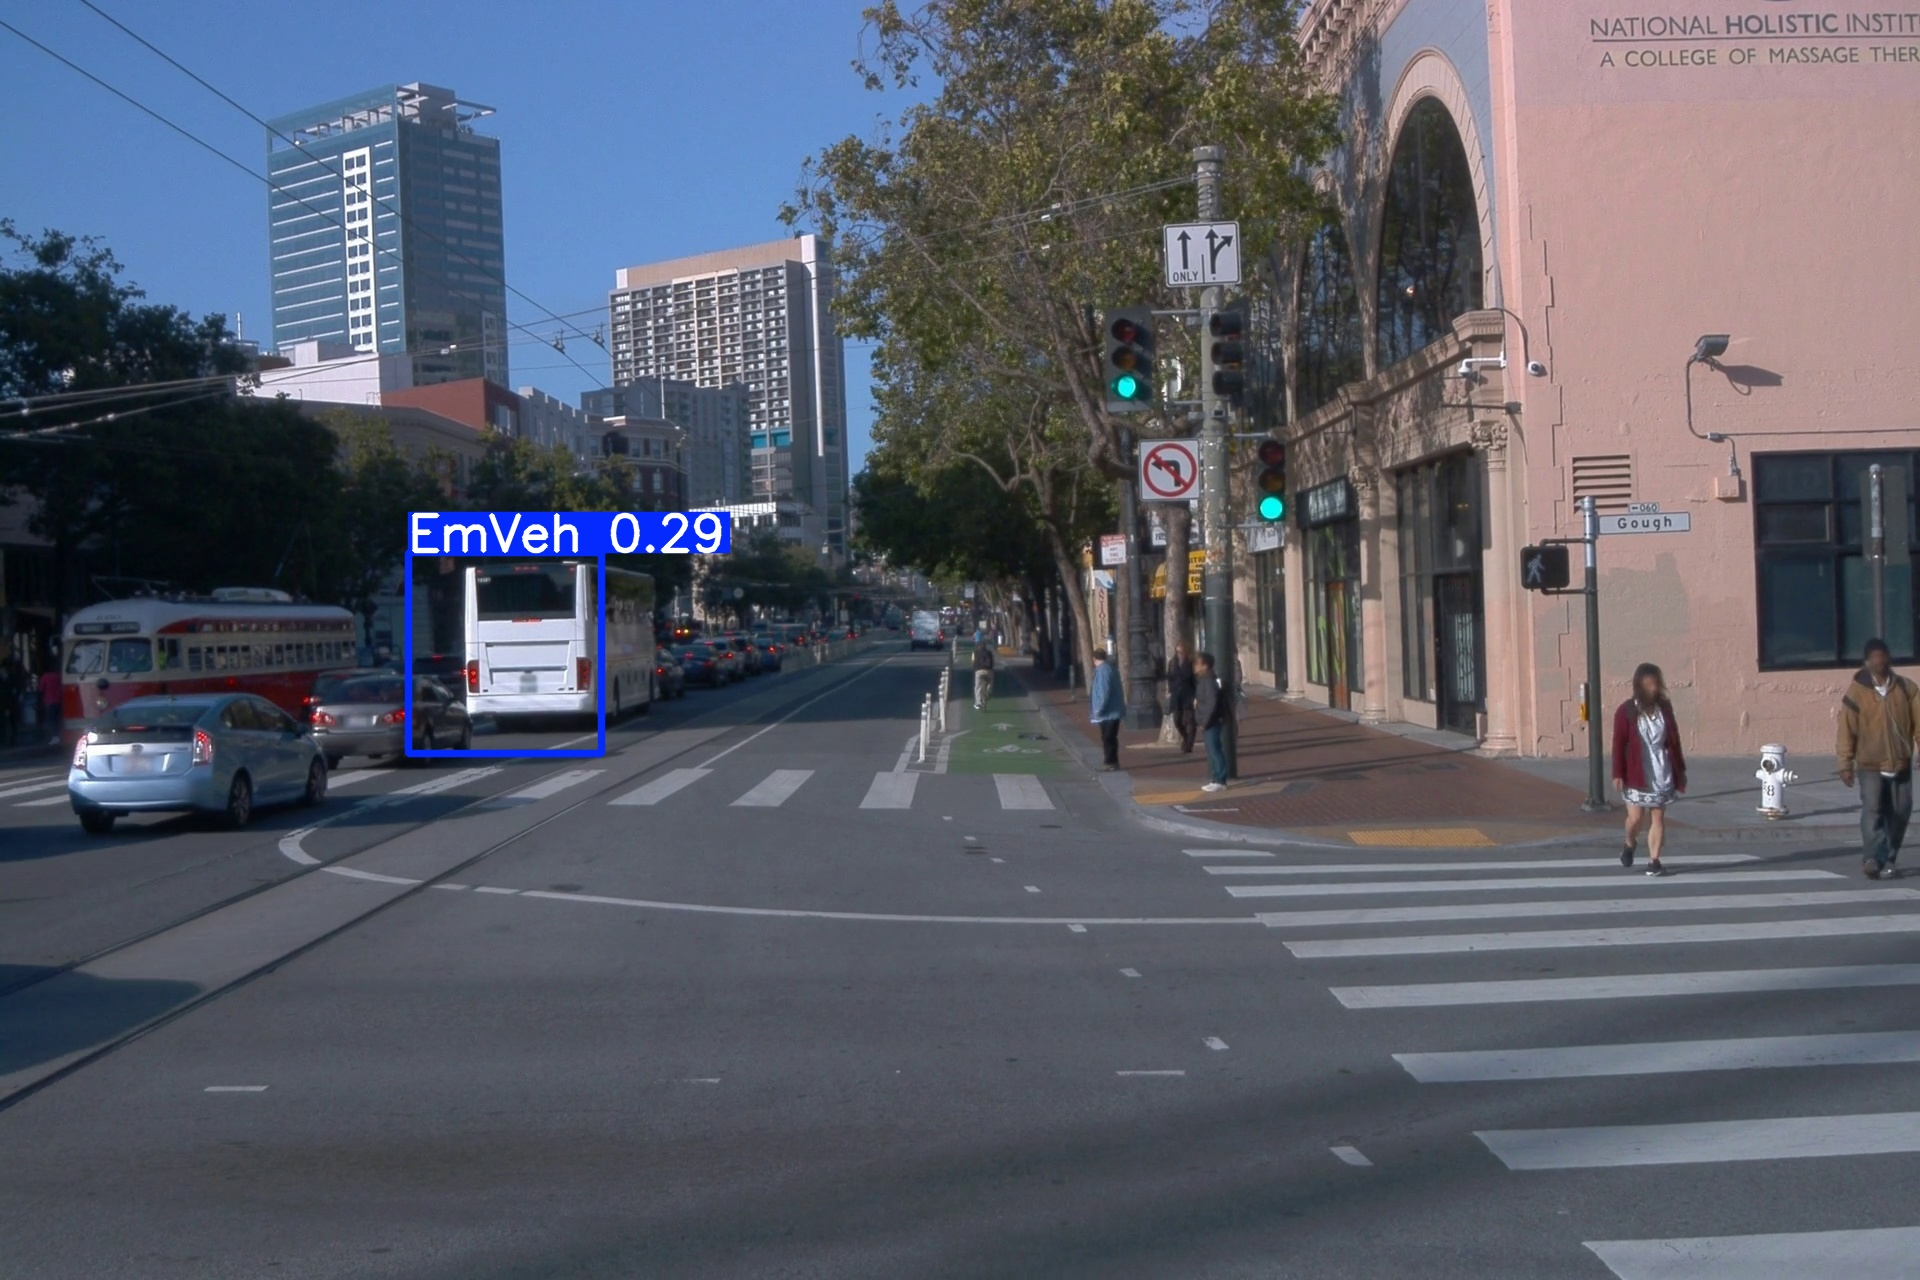

Image: train_00269_135.jpg
Detections: 1
Confidence scores: ['0.29']



image 1/1 /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00164_123.jpg: 448x640 4 EmVehs, 8.6ms
Speed: 2.7ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


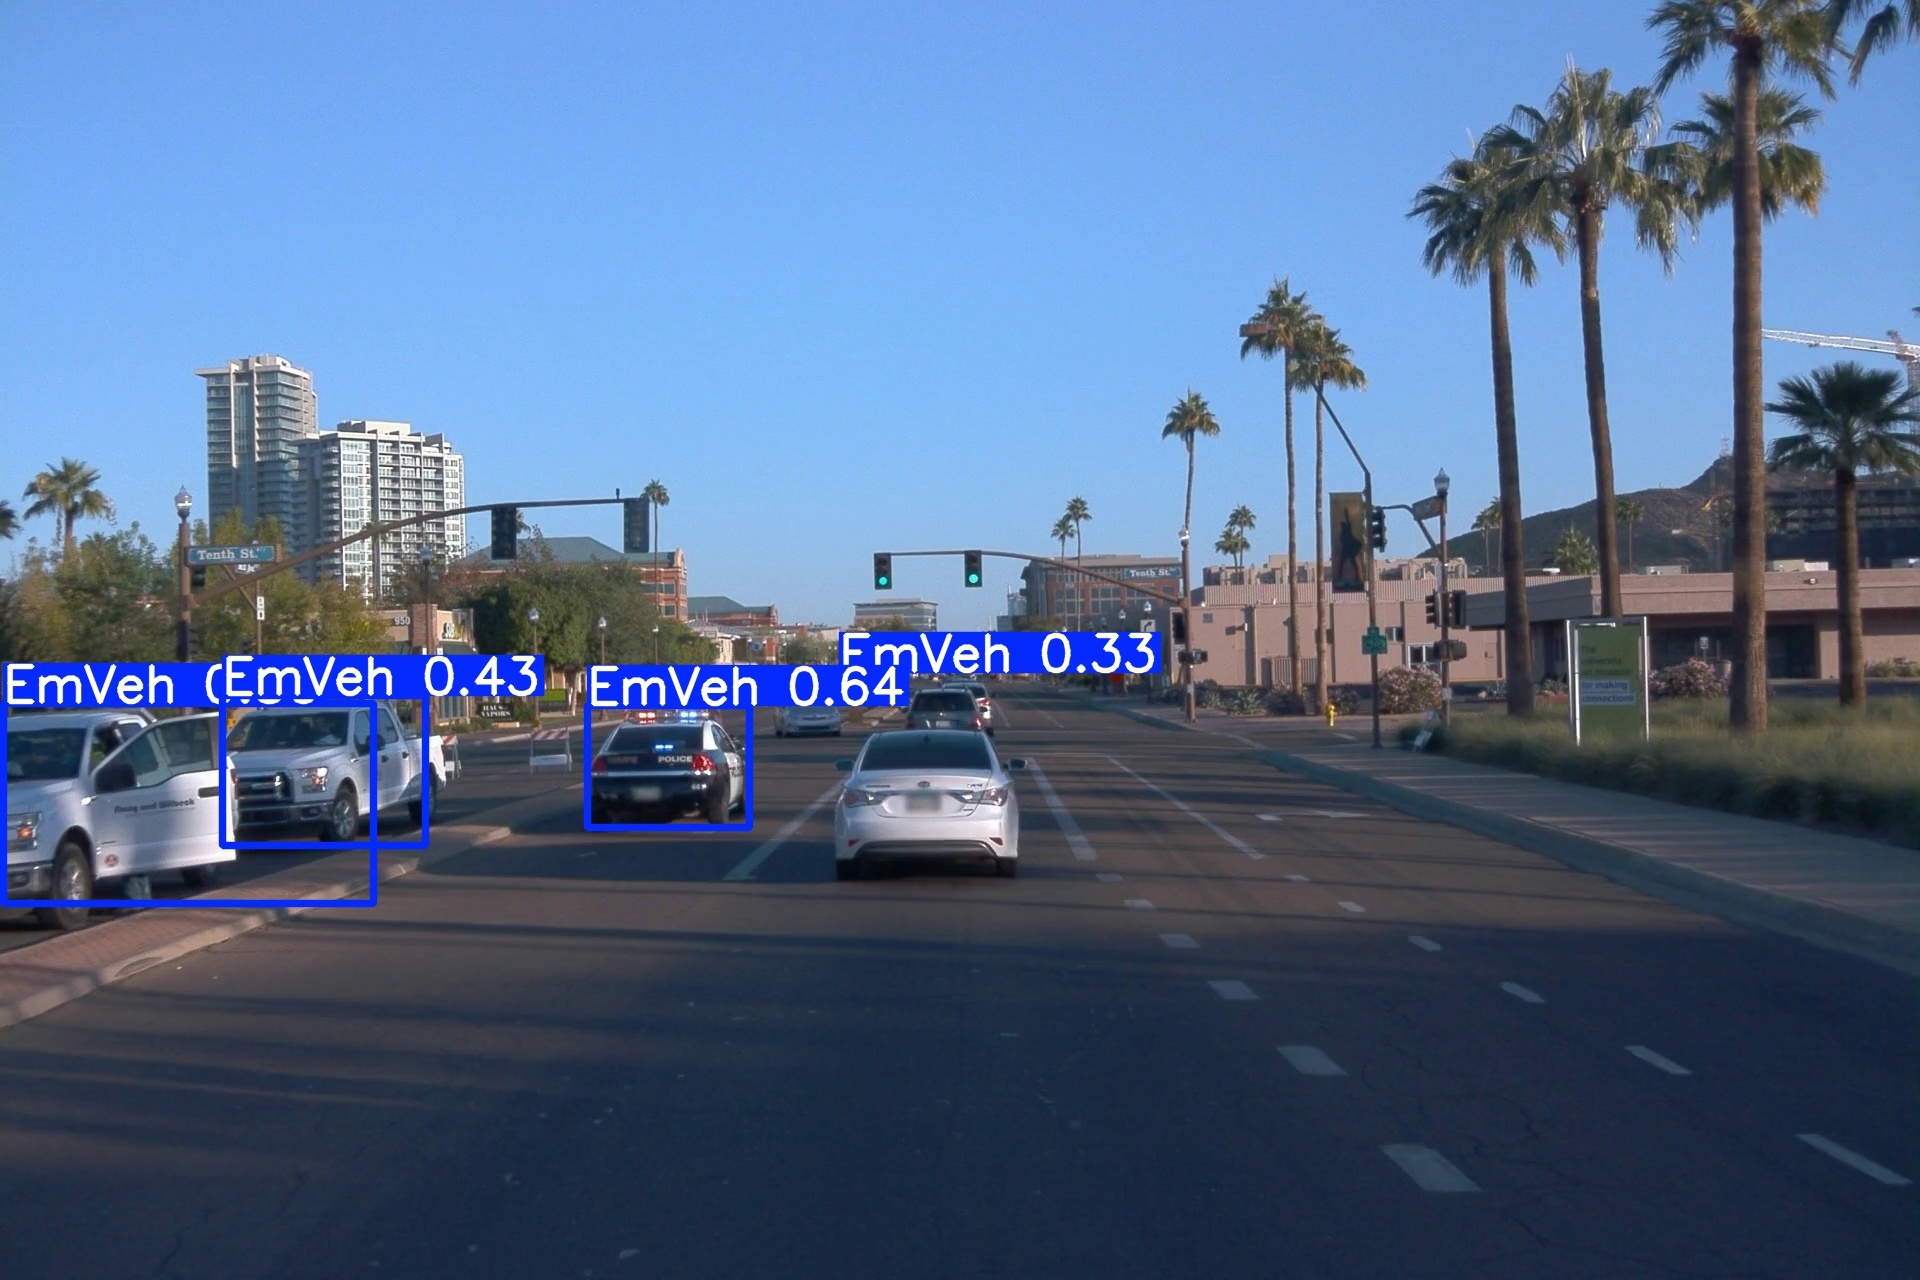

Image: train_00164_123.jpg
Detections: 4
Confidence scores: ['0.64', '0.43', '0.33', '0.30']



image 1/1 /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00022_133.jpg: 448x640 (no detections), 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


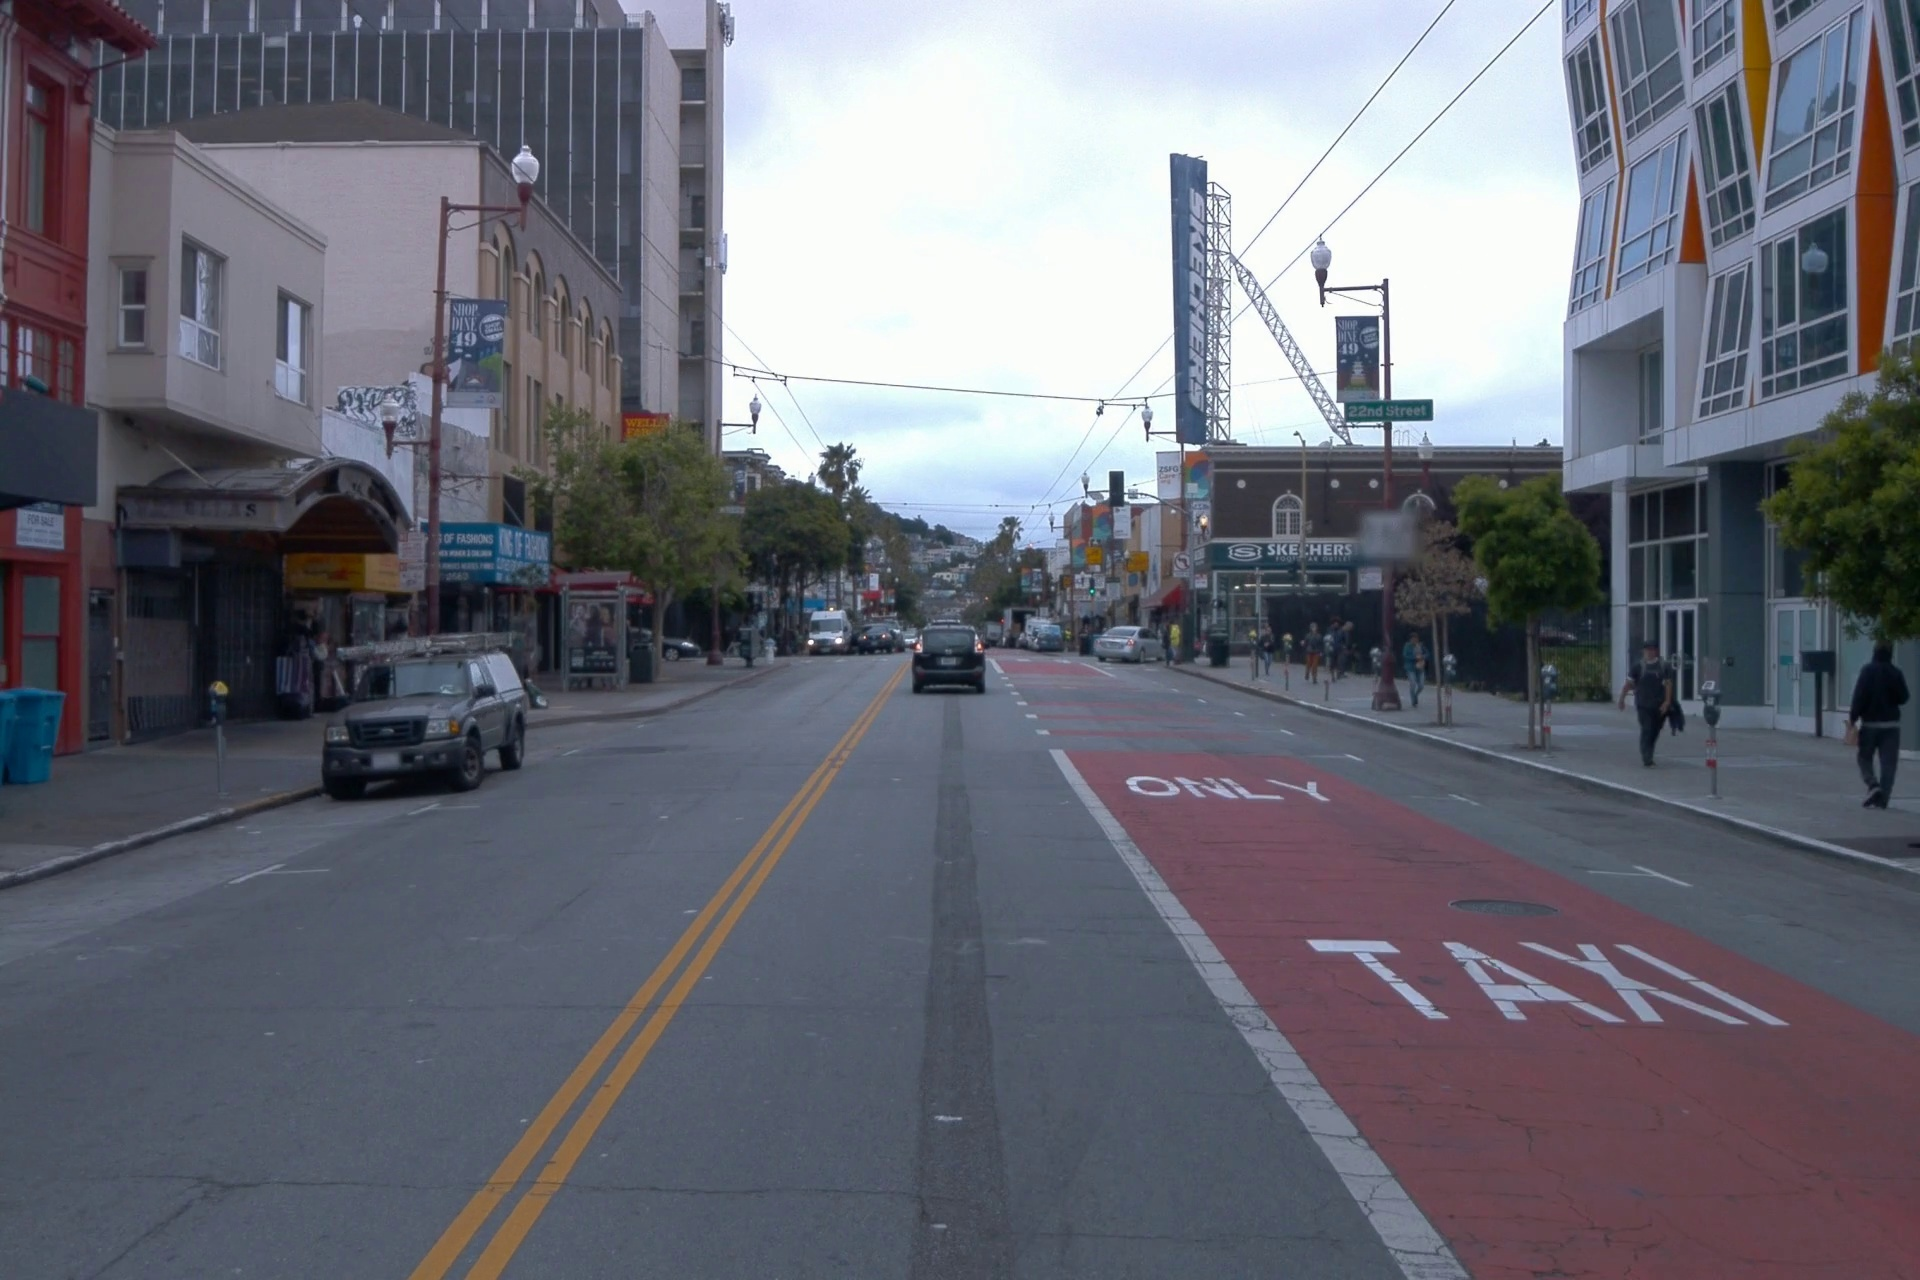

Image: train_00022_133.jpg
Detections: 0



image 1/1 /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00022_176.jpg: 448x640 1 EmVeh, 10.5ms
Speed: 4.4ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


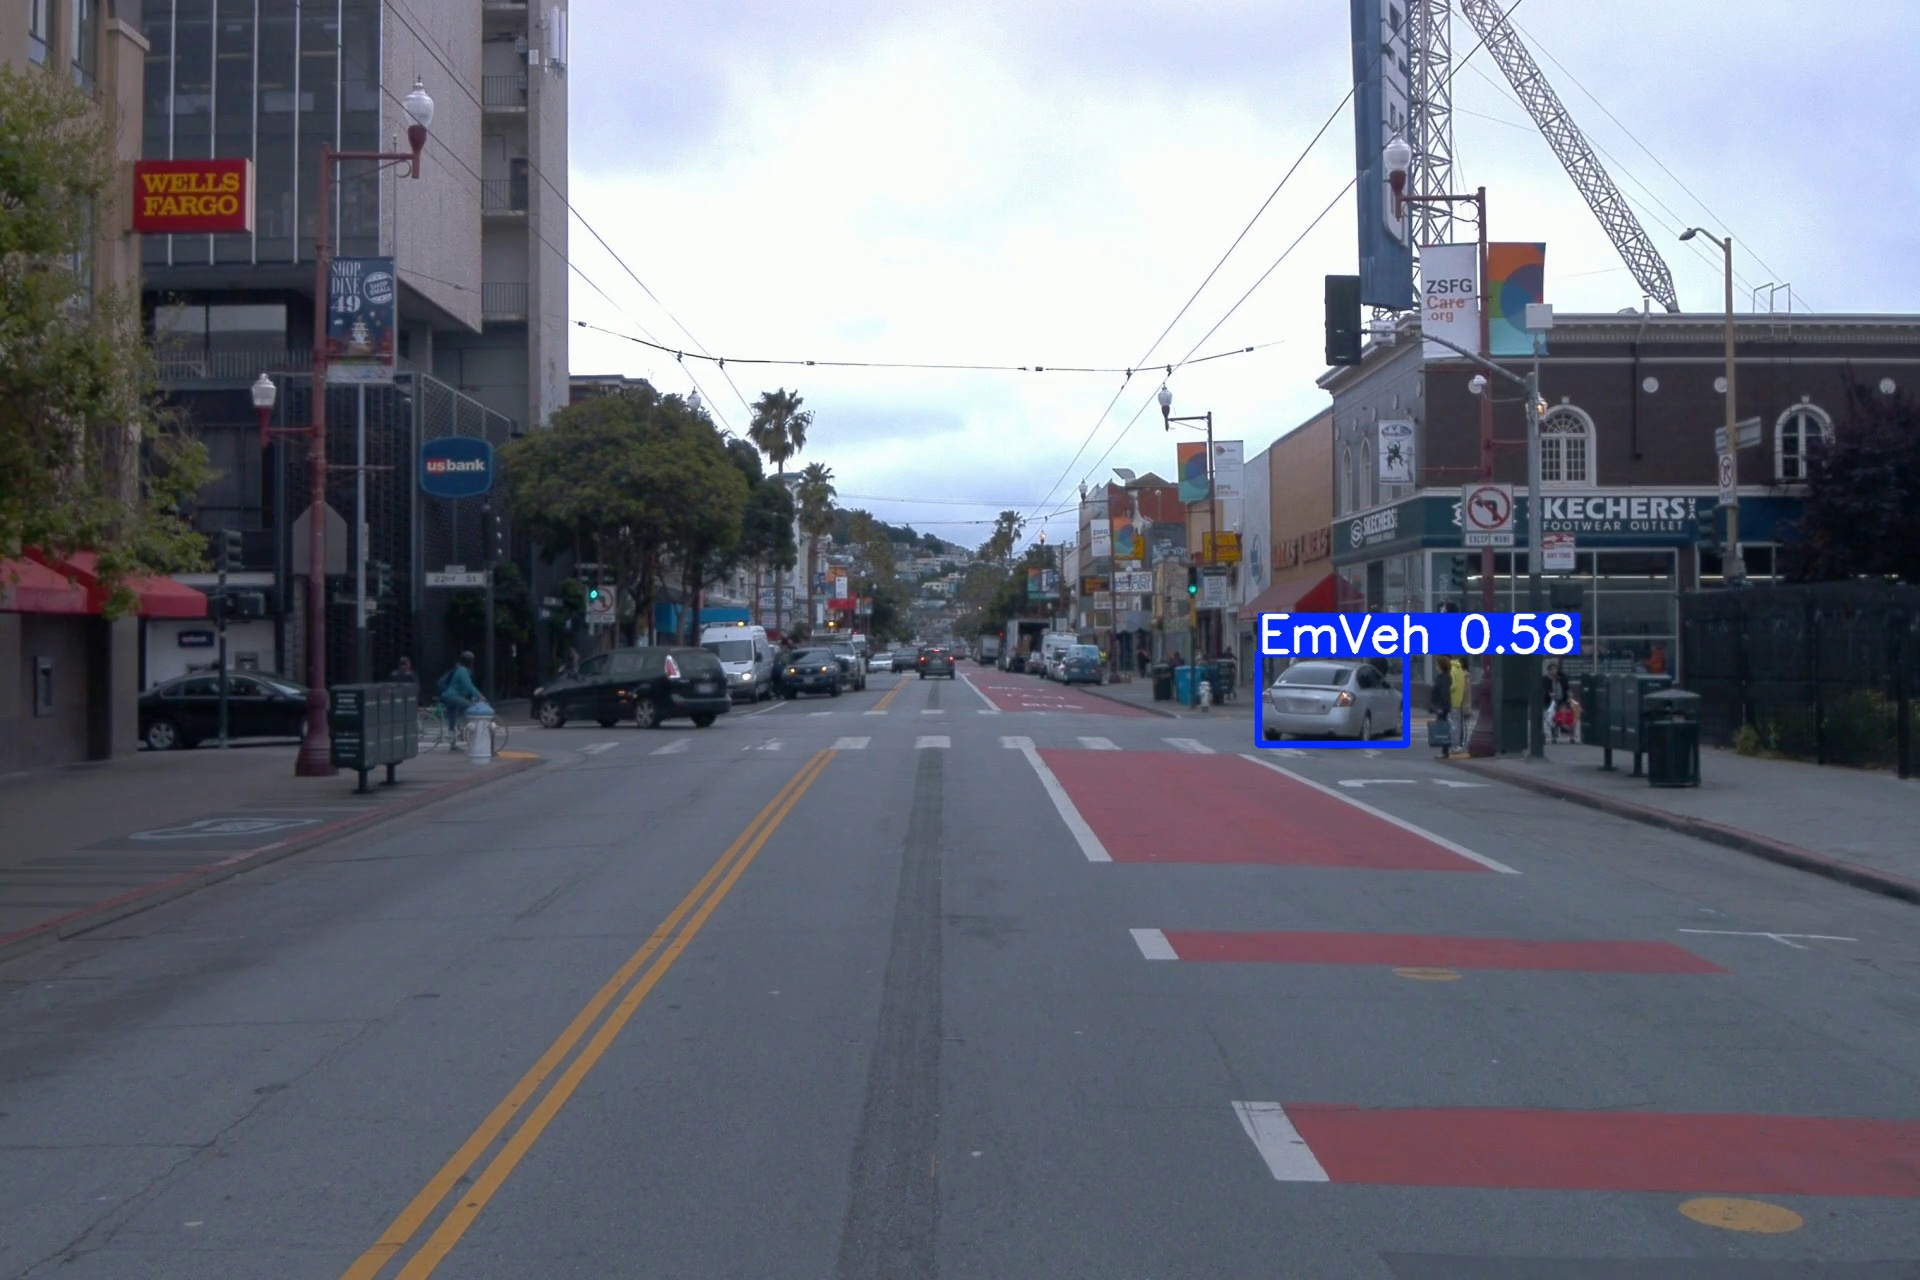

Image: train_00022_176.jpg
Detections: 1
Confidence scores: ['0.58']



image 1/1 /content/waymo_emergency_vehicle_detection/yolo_dataset/val/images/train_00581_110.jpg: 448x640 1 EmVeh, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


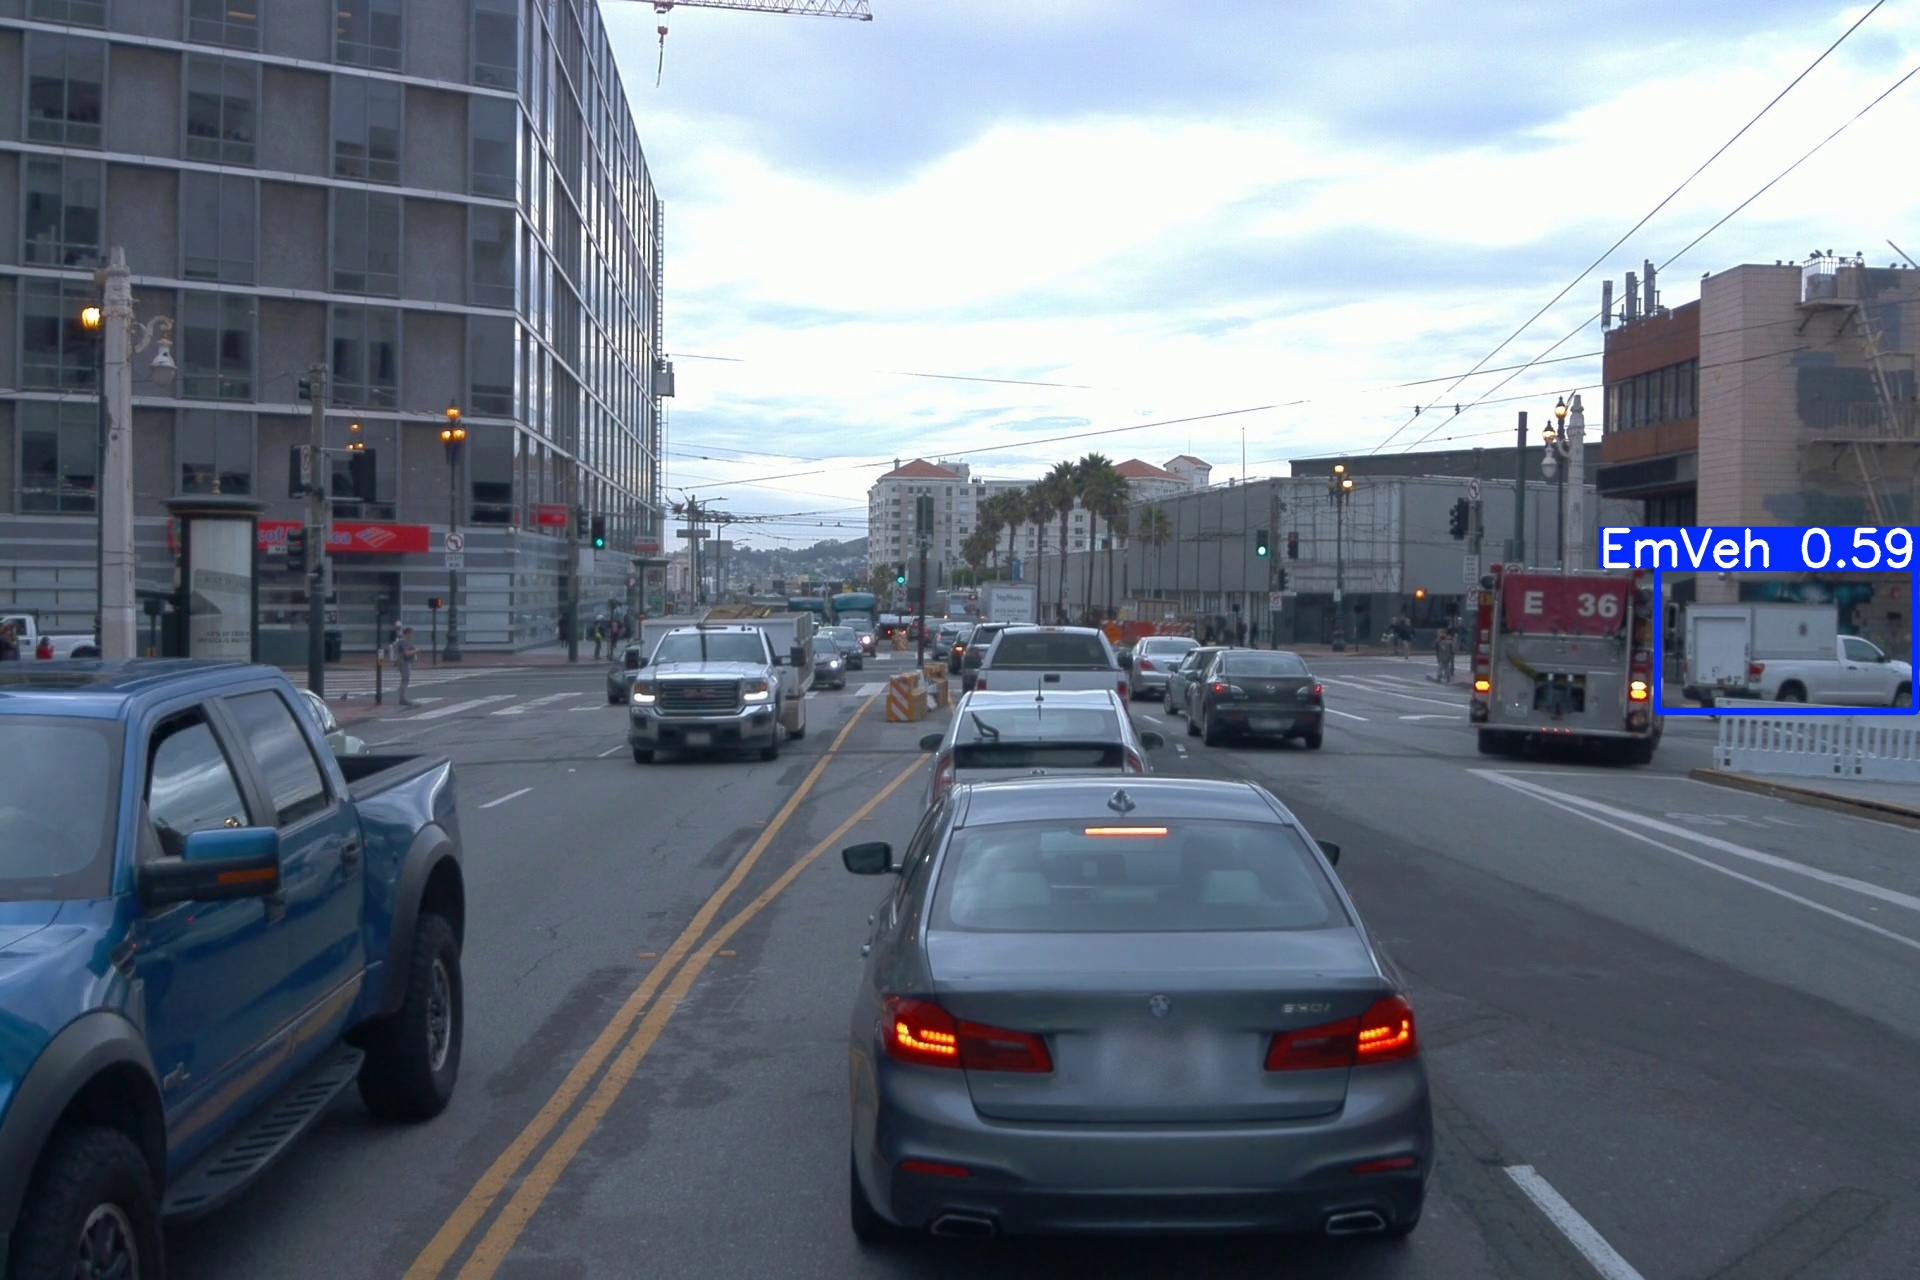

Image: train_00581_110.jpg
Detections: 1
Confidence scores: ['0.59']



Step 4: Running inference on test videos...
Processing video: train_00540.mp4

0: 448x640 1 EmVeh, 9.9ms
Speed: 7.7ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 EmVeh, 11.6ms
Speed: 4.4ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 4 EmVehs, 11.9ms
Speed: 4.4ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 EmVeh, 11.8ms
Speed: 4.5ms preprocess, 11.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 EmVeh, 12.0ms
Speed: 4.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 EmVeh, 11.0ms
Speed: 4.3ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 EmVeh, 10.4ms
Speed: 4.4ms preprocess, 10.4ms inference, 1.6ms postprocess per image at

In [7]:
import os
import yaml
from ultralytics import YOLO
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load dataset configuration
with open(os.path.join(YOLO_DIR, 'dataset.yaml'), 'r') as f:
    dataset_config = yaml.safe_load(f)

# Function to train YOLOv8 model
def train_yolo_model(model_size='n', epochs=50, batch_size=16, imgsz=640, patience=10):
    """
    Train a YOLOv8 model on our emergency vehicle dataset

    Args:
        model_size: Model size - 'n', 's', 'm', 'l', or 'x' (default: 'n')
        epochs: Number of training epochs (default: 50)
        batch_size: Batch size (default: 16)
        imgsz: Image size (default: 640)
        patience: Early stopping patience (default: 10)

    Returns:
        Trained model
    """
    # Load a pre-trained YOLOv8 model
    model = YOLO(f'yolov8{model_size}.pt')

    # Train the model
    results = model.train(
        data=os.path.join(YOLO_DIR, 'dataset.yaml'),
        epochs=epochs,
        batch=batch_size,
        imgsz=imgsz,
        patience=patience,
        save=True,
        project=RESULTS_DIR,
        name=f'yolov8{model_size}_emergency_vehicles',
        exist_ok=True,

    )

    return model, results

def evaluate_model(model):
    """
    Evaluate the trained model on the validation set

    Args:
        model: Trained YOLOv8 model
    """
    # Run validation
    results = model.val(
        data=os.path.join(YOLO_DIR, 'dataset.yaml')
    )

    # Display metrics
    metrics = results.box.map    # Mean Average Precision

    # Handle array metrics correctly
    if hasattr(results.box, 'p') and hasattr(results.box.p, 'mean'):
        precision = results.box.p.mean()
    else:
        precision = float(results.box.p) if hasattr(results.box, 'p') else 0

    if hasattr(results.box, 'r') and hasattr(results.box.r, 'mean'):
        recall = results.box.r.mean()
    else:
        recall = float(results.box.r) if hasattr(results.box, 'r') else 0

    if hasattr(results.box, 'f1') and hasattr(results.box.f1, 'mean'):
        f1 = results.box.f1.mean()
    else:
        f1 = float(results.box.f1) if hasattr(results.box, 'f1') else 0

    print(f"Model Performance Metrics:")
    print(f"mAP@0.5:0.95: {metrics:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return results

# Function to visualize predictions on sample images
def visualize_predictions(model, num_samples=5):
    """
    Visualize model predictions on sample validation images

    Args:
        model: Trained YOLOv8 model
        num_samples: Number of samples to visualize (default: 5)
    """
    # Get validation image paths
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        image_files = np.random.choice(image_files, num_samples, replace=False)

    # Run predictions and visualize
    for img_path in image_files:
        # Run prediction
        results = model.predict(img_path, conf=0.25)

        # Generate and display visualization
        fig_path = os.path.join(RESULTS_DIR, f"pred_{os.path.basename(img_path)}")

        # Get the raw prediction image with bounding boxes
        result_img = results[0].plot()
        cv2.imwrite(fig_path, result_img)

        # Display the image
        display(Image(filename=fig_path))

        # Print detection details
        boxes = results[0].boxes
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Detections: {len(boxes)}")

        if len(boxes) > 0:
            print("Confidence scores:", [f"{conf:.2f}" for conf in boxes.conf.tolist()])
        print("\n")

# Function to run inference on test videos
def run_inference_on_videos(model, num_videos=2, frame_skip=10):
    """
    Run inference on test videos and create visualization videos

    Args:
        model: Trained YOLOv8 model
        num_videos: Number of videos to process (default: 2)
        frame_skip: Process every Nth frame for speed (default: 10)
    """
    # Get list of video files
    videos_dir = os.path.join(BASE_DIR, "data", "videos")
    all_videos = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir) if f.endswith('.mp4')]

    # Select random videos
    if len(all_videos) > num_videos:
        videos = np.random.choice(all_videos, num_videos, replace=False)
    else:
        videos = all_videos

    for video_path in videos:
        video_name = os.path.basename(video_path)
        output_path = os.path.join(RESULTS_DIR, f"pred_{video_name}")

        print(f"Processing video: {video_name}")

        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Create video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps/frame_skip, (width, height))

        frame_count = 0
        processed_count = 0

        # Process frames
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process every frame_skip frames
            if frame_count % frame_skip == 0:
                # Run prediction
                results = model.predict(frame, conf=0.25)

                # Draw predictions on frame
                result_frame = results[0].plot()

                # Write frame to output video
                out.write(result_frame)
                processed_count += 1

                # Print progress
                if processed_count % 10 == 0:
                    print(f"Processed {processed_count} frames ({frame_count}/{total_frames})")

            frame_count += 1

        # Release resources
        cap.release()
        out.release()

        print(f"Video saved to {output_path}")

# Main execution
if __name__ == "__main__":
    # Install the required packages
    !pip install ultralytics

    # Step 1: Train the model
    print("Step 1: Training YOLOv8 model...")
    model, training_results = train_yolo_model(
        model_size='s',    # 's' for small, faster training
        epochs=25,         # Reduce for faster training, increase for better performance
        batch_size=16,     # Adjust based on available memory
        imgsz=640,         # Standard YOLO image size
        patience=5         # Early stopping patience
    )

    # Step 2: Evaluate the model
    print("\nStep 2: Evaluating model performance...")
    evaluation_results = evaluate_model(model)

    # Step 3: Visualize predictions on sample images
    print("\nStep 3: Visualizing predictions on sample images...")
    visualize_predictions(model, num_samples=5)

    # Step 4: Run inference on test videos
    print("\nStep 4: Running inference on test videos...")
    run_inference_on_videos(model, num_videos=2, frame_skip=5)

    print("\nModel training and evaluation complete!")

    # Optional: Save results to Google Drive
    drive.mount('/content/drive')
    save_dir = '/content/drive/MyDrive/emergency_vehicle_detection'
    os.makedirs(save_dir, exist_ok=True)

    # Copy result files
    !cp -r {RESULTS_DIR}/* {save_dir}/
    print(f"Results saved to Google Drive: {save_dir}")

### Testing

In [11]:
import os
from ultralytics import YOLO
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODEL_DIR = os.path.join(RESULTS_DIR, "yolov8s_emergency_vehicles")
WEIGHTS_DIR = os.path.join(MODEL_DIR, "weights")

# Path to your trained model
model_path = os.path.join(WEIGHTS_DIR, "best.pt")  # Adjust filename if different

# Load the model
model = YOLO(model_path)
print(f"Model loaded from {model_path}")

# Function to test on single image
def test_on_single_image(image_path, conf=0.25):
    """Test model on a single image and display results"""
    # Run prediction
    results = model.predict(image_path, conf=conf, save=True)[0]

    # Get and display the result image
    result_image = results.plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Predictions on {os.path.basename(image_path)}")
    plt.show()

    # Print detection details
    boxes = results.boxes
    print(f"Found {len(boxes)} emergency vehicles")

    if len(boxes) > 0:
        print("\nDetection details:")
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            confidence = box.conf[0].item()
            print(f"Detection {i+1}: Confidence: {confidence:.4f}, Coordinates: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")

    return results

# Function to process a video
def test_on_video(video_path, output_path=None, conf=0.25):
    """Process a video with the trained model"""
    if output_path is None:
        # Create output directory if it doesn't exist
        output_dir = os.path.join(RESULTS_DIR, "video_tests")
        os.makedirs(output_dir, exist_ok=True)

        # Generate output filename
        video_name = os.path.basename(video_path)
        output_path = os.path.join(output_dir, f"detected_{video_name}")

    # Run prediction on video
    results = model.predict(
        source=video_path,
        conf=conf,
        save=True,
        project=os.path.dirname(output_path),
        name=os.path.basename(output_path).split('.')[0]
    )

    print(f"Video processing complete. Output saved to: {output_path}")
    return output_path

# Function to evaluate on validation set
def evaluate_on_val_set():
    """Evaluate model performance on validation set"""
    # Define validation data path
    val_data = os.path.join(YOLO_DIR, "dataset.yaml")

    # Run validation
    results = model.val(data=val_data)

    # Extract and print metrics
    metrics = results.box.map    # Mean Average Precision
    precision = results.box.p.mean() if hasattr(results.box.p, 'mean') else float(results.box.p)
    recall = results.box.r.mean() if hasattr(results.box.r, 'mean') else float(results.box.r)
    f1 = results.box.f1.mean() if hasattr(results.box.f1, 'mean') else float(results.box.f1)

    print(f"\nModel Performance Metrics:")
    print(f"mAP@0.5:0.95: {metrics:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return results

# Function to batch process test samples
def test_on_sample_images(num_samples=5, conf=0.25):
    """Test on multiple random samples from validation set"""
    # Get validation images
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        selected_images = random.sample(image_files, num_samples)
    else:
        selected_images = image_files

    # Process each image
    for img_path in selected_images:
        print(f"\nProcessing image: {os.path.basename(img_path)}")
        test_on_single_image(img_path, conf=conf)

Model loaded from /content/waymo_emergency_vehicle_detection/results/yolov8s_emergency_vehicles/weights/best.pt


In [39]:
# 1. Evaluate model on the validation set
#print("Evaluating model on validation set...")
#evaluate_on_val_set()  # Use cli_evaluate_on_val_set() for CLI approach

# 2. Test on random sample images
#print("\nTesting on random sample images...")
#test_on_sample_images(num_samples=3, conf=0.25)  # Use cli_test_on_sample_images() for CLI approach

# 3. Test on a specific image
#print("\nTesting on a specific image...")
#specific_image = os.path.join(YOLO_DIR, 'val', 'images', 'train_00164_135.jpg')  # Adjust to an actual image path
#test_on_single_image(specific_image, conf=0.25)  # Use cli_test_on_image() for CLI approach

# 4. Process a video
#print("\nProcessing a test video...")
video_path = os.path.join(BASE_DIR, "data", "videos", "train_00599.mp4")  # Adjust to an actual video
test_on_video(video_path, conf=0.25)  # Use cli_test_on_video() for CLI approach


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 10.0ms
video 1/1 (frame 2/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 8.5ms
video 1/1 (frame 3/198) /content/waymo_emergency_vehicle_detection/data/videos/train_00599.mp4: 448x640 (no detections), 8.5ms
video 1/1 (frame 4/198) /content/waymo_emergency_vehicle_detection/data/vi

'/content/waymo_emergency_vehicle_detection/results/video_tests/detected_train_00599.mp4'

## Medium YOLO Model (NOT WORKING YET)

In [10]:
import os
import yaml
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time

# Define directories
BASE_DIR = "/content/waymo_emergency_vehicle_detection"
YOLO_DIR = os.path.join(BASE_DIR, "yolo_dataset")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODEL_DIR = os.path.join(RESULTS_DIR, "models")

# Create necessary directories
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Function to train using os.system to ensure progress is visible
def train_yolo_model_cli(model_size='m', epochs=100, batch_size=8, imgsz=1280, patience=15):
    """Train a YOLOv8 model with visible progress"""
    model_path = f"yolov8{model_size}.pt"
    project_dir = os.path.join(RESULTS_DIR, f"yolov8{model_size}_run")

    # Build the command
    cmd = [
        "yolo", "detect", "train",
        f"model={model_path}",
        f"data={os.path.join(YOLO_DIR, 'dataset.yaml')}",
        f"epochs={epochs}",
        f"imgsz={imgsz}",
        f"batch={batch_size}",
        f"patience={patience}",
        f"project={project_dir}",
        "name=train",
        "exist_ok=True",
        "verbose=True"  # Ensure verbose output
    ]

    # Execute the command with os.system to show real-time progress
    cmd_str = " ".join(cmd)
    print(f"Running training command: {cmd_str}")

    # Using os.system ensures the output is displayed in real-time
    os.system(cmd_str)

    # Find the best weights path
    best_weights_path = os.path.join(project_dir, "train", "weights", "best.pt")
    if os.path.exists(best_weights_path):
        # Copy to our models directory with a descriptive name
        target_path = os.path.join(MODEL_DIR, f"yolov8{model_size}_emveh_i{imgsz}_e{epochs}.pt")
        os.system(f"cp {best_weights_path} {target_path}")
        print(f"Best model saved to {target_path}")
        return target_path
    else:
        print("Warning: Could not find best weights file")
        return None

# Function to evaluate a model with visible progress
def evaluate_model_cli(weights_path):
    """Evaluate model with visible progress"""
    cmd = [
        "yolo", "detect", "val",
        f"model={weights_path}",
        f"data={os.path.join(YOLO_DIR, 'dataset.yaml')}",
        "verbose=True"  # Ensure verbose output
    ]

    cmd_str = " ".join(cmd)
    print(f"Running evaluation command: {cmd_str}")

    # Using os.system for real-time output
    os.system(cmd_str)

# Function to run predictions on sample images
def predict_on_samples(weights_path, num_samples=5):
    """Run predictions on sample images from validation set"""
    # Get validation images
    val_images_dir = os.path.join(YOLO_DIR, 'val', 'images')
    image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.jpg')]

    if len(image_files) == 0:
        print("No validation images found")
        return

    # Select random samples
    if len(image_files) > num_samples:
        selected_images = random.sample(image_files, num_samples)
    else:
        selected_images = image_files

    # Create output directory for visualizations
    vis_dir = os.path.join(RESULTS_DIR, "visualizations")
    os.makedirs(vis_dir, exist_ok=True)

    # Save sample paths to a temporary file
    with open("/tmp/sample_images.txt", "w") as f:
        for img_path in selected_images:
            f.write(f"{img_path}\n")

    # Run prediction with visible progress
    cmd = [
        "yolo", "detect", "predict",
        f"model={weights_path}",
        f"source=/tmp/sample_images.txt",
        "save=True",
        f"project={vis_dir}",
        "conf=0.25",
        "exist_ok=True",
        "verbose=True"  # Ensure verbose output
    ]

    cmd_str = " ".join(cmd)
    print(f"Running prediction command: {cmd_str}")
    os.system(cmd_str)

    # Display results
    pred_dir = os.path.join(vis_dir, "predict")
    if os.path.exists(pred_dir):
        result_images = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if f.endswith('.jpg')]
        for img_path in result_images:
            display(Image(filename=img_path))
            print(f"Visualization: {os.path.basename(img_path)}")

# Function to process a test video with visible progress
def process_test_video(weights_path, num_videos=1):
    """Process a test video with visible progress"""
    # Get list of video files
    videos_dir = os.path.join(BASE_DIR, "data", "videos")
    all_videos = [os.path.join(videos_dir, f) for f in os.listdir(videos_dir) if f.endswith('.mp4')]

    if not all_videos:
        print("No videos found for inference")
        return

    # Select random videos
    if len(all_videos) > num_videos:
        selected_videos = random.sample(all_videos, num_videos)
    else:
        selected_videos = all_videos

    # Create output directory
    vid_output_dir = os.path.join(RESULTS_DIR, "video_predictions")
    os.makedirs(vid_output_dir, exist_ok=True)

    # Process each video
    for video_path in selected_videos:
        video_name = os.path.basename(video_path)
        print(f"Processing video: {video_name}")

        # Run prediction with visible progress
        cmd = [
            "yolo", "detect", "predict",
            f"model={weights_path}",
            f"source={video_path}",
            "save=True",
            f"project={vid_output_dir}",
            "conf=0.25",
            "exist_ok=True",
            "verbose=True"  # Ensure verbose output
        ]

        cmd_str = " ".join(cmd)
        print(f"Running video prediction command: {cmd_str}")
        os.system(cmd_str)

        print(f"Video prediction complete: {video_name}")

# Main execution
if __name__ == "__main__":
    # Fix for potential CUDA errors
    import gc
    import torch
    torch.cuda.empty_cache()
    gc.collect()

    # Step 1: Train the model with visible progress
    print("\n=== Step 1: Training YOLOv8 Model ===")
    print("Training will start in 5 seconds - Progress will be visible")
    time.sleep(5)  # Give a moment to see the message

    model_weights = train_yolo_model_cli(
        model_size='m',         # Medium model for better accuracy
        epochs=50,              # 50 epochs should be enough
        batch_size=8,           # Reduced batch size for higher resolution
        imgsz=1280,             # Higher resolution for better small object detection
        patience=15             # Increased patience for better convergence
    )

    if model_weights and os.path.exists(model_weights):
        # Step 2: Evaluate the model
        print("\n=== Step 2: Evaluating Model Performance ===")
        evaluate_model_cli(model_weights)

        # Step 3: Run predictions on sample images
        print("\n=== Step 3: Generating Sample Predictions ===")
        predict_on_samples(model_weights, num_samples=5)

        # Step 4: Process a test video
        print("\n=== Step 4: Processing Test Video ===")
        process_test_video(model_weights, num_videos=1)

        print("\nAll tasks completed successfully!")
    else:
        print("Model training failed or model weights not found.")


=== Step 1: Training YOLOv8 Model ===
Training will start in 5 seconds - Progress will be visible
Running training command: yolo detect train model=yolov8m.pt data=/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml epochs=50 imgsz=1280 batch=8 patience=15 project=/content/waymo_emergency_vehicle_detection/results/yolov8m_run name=train exist_ok=True verbose=True
Best model saved to /content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt

=== Step 2: Evaluating Model Performance ===
Running evaluation command: yolo detect val model=/content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt data=/content/waymo_emergency_vehicle_detection/yolo_dataset/dataset.yaml verbose=True

=== Step 3: Generating Sample Predictions ===
Running prediction command: yolo detect predict model=/content/waymo_emergency_vehicle_detection/results/models/yolov8m_emveh_i1280_e50.pt source=/tmp/sample_images.txt save=True project=/content/